# Training

This treats the spectrograms of the words like images

In [1]:
# Import all the things we will need
import datetime
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.data import Dataset
import matplotlib.pyplot as plt

In [2]:
model_name = "hikiwi-01"

In [3]:
# Load the TensorBoard notebook extension - if you want it inline - this can be a bit flaky...
# %load_ext tensorboard
# %reload_ext tensorboard

In [4]:
# clear out any old logs
!rm -rf ./logs/ 

In [5]:
# List of the words in categorical order
words = [
    'hikiwi',
    'backward',
    'bed',
    'bird',
    'cat',
    'dog',
    'down',
    'eight',
    'five',
    'follow',
    'forward',
    'four',
    'go',
    'happy',
    'house',
    'learn',
    'left',
    'marvin',
    'nine',
    'no',
    'off',
    'on',
    'one',
    'right',
    'seven',
    'sheila',
    'six',
    'stop',
    'three',
    'tree',
    'two',
    'up',
    'visual',
    'wow',
    'yes',
    'zero',
    '_background',
]

In [6]:
# Load up the sprectrograms and labels
training_spectrogram = np.load('training_spectrogram.npz')
validation_spectrogram = np.load('validation_spectrogram.npz')
test_spectrogram = np.load('test_spectrogram.npz')

In [7]:
# extract the data from the files
X_train = training_spectrogram['X']
Y_train_cats = training_spectrogram['Y']
X_validate = validation_spectrogram['X']
Y_validate_cats = validation_spectrogram['Y']
X_test = test_spectrogram['X']
Y_test_cats = test_spectrogram['Y']

# get the width and height of the spectrogram "image"
IMG_WIDTH=X_train[0].shape[0]
IMG_HEIGHT=X_train[0].shape[1]

(array([80880.,   991.,   470.,   697.,   536.,   760.,  1466.,   959.,
          944.,   460.,   681.,   897.,   805.,   671.,   823.,   648.,
         1302.,  1258.,  1942.,  1172.,   593.,  1118.,  1088.,  1117.,
         1728.,  1262.,  1911.,  1032.,  1037.,   734.,   921.,   414.,
          944.,   841.,  1611.,  2405.,  5424.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <BarContainer object of 37 artists>)

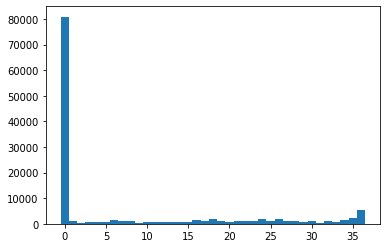

In [8]:
# plot a distribution of the words
plt.hist(Y_train_cats, bins=range(0,len(words)+1), align='left')

In [9]:
unique, counts = np.unique(Y_train_cats, return_counts=True)
print(unique, counts)
dict(zip([words[i] for i in unique], counts))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36] [80880   991   470   697   536   760  1466   959   944   460   681   897
   805   671   823   648  1302  1258  1942  1172   593  1118  1088  1117
  1728  1262  1911  1032  1037   734   921   414   944   841  1611  2405
  5424]


{'hikiwi': 80880,
 'backward': 991,
 'bed': 470,
 'bird': 697,
 'cat': 536,
 'dog': 760,
 'down': 1466,
 'eight': 959,
 'five': 944,
 'follow': 460,
 'forward': 681,
 'four': 897,
 'go': 805,
 'happy': 671,
 'house': 823,
 'learn': 648,
 'left': 1302,
 'marvin': 1258,
 'nine': 1942,
 'no': 1172,
 'off': 593,
 'on': 1118,
 'one': 1088,
 'right': 1117,
 'seven': 1728,
 'sheila': 1262,
 'six': 1911,
 'stop': 1032,
 'three': 1037,
 'tree': 734,
 'two': 921,
 'up': 414,
 'visual': 944,
 'wow': 841,
 'yes': 1611,
 'zero': 2405,
 '_background': 5424}

In [10]:
Y_train = [1 if y == words.index('hikiwi') else 0 for y in Y_train_cats]
Y_validate = [1 if y == words.index('hikiwi') else 0 for y in Y_validate_cats]
Y_test = [1 if y == words.index('hikiwi') else 0 for y in Y_test_cats]

(array([41662., 80880.]), array([0, 1, 2]), <BarContainer object of 2 artists>)

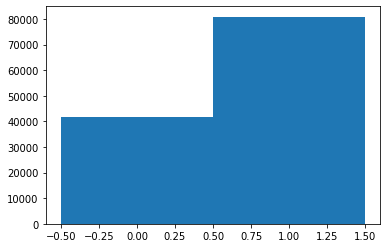

In [11]:
plt.hist(Y_train, bins=range(0,3), align='left')

In [12]:
# create the datasets for training
batch_size = 30

train_dataset = Dataset.from_tensor_slices(
    (X_train, Y_train)
).repeat(
    count=-1
).shuffle(
    len(X_train)
).batch(
    batch_size
)

validation_dataset = Dataset.from_tensor_slices((X_validate, Y_validate)).batch(X_validate.shape[0])

test_dataset = Dataset.from_tensor_slices((X_test, Y_test)).batch(len(X_test))

2023-04-24 00:59:26.181237: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31009 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:8a:00.0, compute capability: 7.0


In [13]:
model = Sequential([
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer1',
           input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
    MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
    Conv2D(4, 3, 
           padding='same',
           activation='relu',
           kernel_regularizer=regularizers.l2(0.001),
           name='conv_layer2'),
    MaxPooling2D(name='max_pooling2', pool_size=(2,2)),
    Flatten(),
    Dropout(0.3),
    Dense(
        48,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        name='hidden_layer1'
    ),
    Dense(
        1, 
        activation='sigmoid',
        kernel_regularizer=regularizers.l2(0.001),
        name='output'
    )
])

# model = Sequential([
#     Conv2D(4, 3, 
#            padding='same',
#            activation='relu',
#            kernel_regularizer=regularizers.l2(0.001),
#            name='conv_layer1',
#            input_shape=(IMG_WIDTH, IMG_HEIGHT, 1)),
# #     MaxPooling2D(name='max_pooling1', pool_size=(2,2)),
#     tf.keras.layers.Reshape((IMG_WIDTH, 43*4)),
#     tf.keras.layers.GRU(32, dropout=0.3),
#     Dense(
#         32,
#         activation='relu',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='hidden_layer1'
#     ),
# #     Dropout(0.2),
# #     Dense(
# #         32,
# #         activation='relu',
# #         kernel_regularizer=regularizers.l2(0.001),
# #         name='hidden_layer2'
# #     ),
#     Dense(
#         1, 
#         activation='sigmoid',
#         kernel_regularizer=regularizers.l2(0.001),
#         name='output'
#     )
# ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 149, 43, 4)        40        
_________________________________________________________________
max_pooling1 (MaxPooling2D)  (None, 74, 21, 4)         0         
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 74, 21, 4)         148       
_________________________________________________________________
max_pooling2 (MaxPooling2D)  (None, 37, 10, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1480)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1480)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 48)                7

In [14]:
epochs=30

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

# Logging to tensorboard
We log the training stats along with the confusion matrix of the test data - should we be using the validation data

In [15]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

2023-04-24 00:59:39.901590: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-04-24 00:59:39.901630: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-04-24 00:59:39.901683: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2023-04-24 00:59:40.303281: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-04-24 00:59:40.303549: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed


# Train model

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="{}-checkpoint.model".format(model_name),
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(
    train_dataset,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
    validation_steps=1,
    callbacks=[tensorboard_callback, model_checkpoint_callback]
)

Epoch 1/30


2023-04-24 00:59:45.540461: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-24 00:59:50.109703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


   1/4084 [..............................] - ETA: 7:57:04 - loss: 0.7716 - accuracy: 0.6000

2023-04-24 00:59:52.076546: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-04-24 00:59:52.076612: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


   7/4084 [..............................] - ETA: 14:18 - loss: 0.7371 - accuracy: 0.6762 

2023-04-24 00:59:53.144329: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-24 00:59:53.144691: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1749] CUPTI activity buffer flushed
2023-04-24 00:59:53.193186: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 519 callback api events and 442 activity events. 
2023-04-24 00:59:53.202535: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-04-24 00:59:53.215385: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/fit/20230424-005939/train/plugins/profile/2023_04_24_00_59_53

2023-04-24 00:59:53.222453: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/fit/20230424-005939/train/plugins/profile/2023_04_24_00_59_53/jarvis-vcjob-bbac89a1727cd5dd9c6b64cf16f35d19-master-0.trace.json.gz
2023-04-24 00:59:53.233792: I tensorflow

4084/4084 [==============================] - 30s 6ms/step - loss: 0.0964 - accuracy: 0.9829 - val_loss: 0.0564 - val_accuracy: 0.9962


2023-04-24 01:00:15.364848: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: hikiwi-01-checkpoint.model/assets
Epoch 2/30
4084/4084 [==============================] - 19s 5ms/step - loss: 0.0599 - accuracy: 0.9931 - val_loss: 0.0510 - val_accuracy: 0.9950
Epoch 3/30
4084/4084 [==============================] - 19s 5ms/step - loss: 0.0537 - accuracy: 0.9941 - val_loss: 0.0494 - val_accuracy: 0.9941
Epoch 4/30
4084/4084 [==============================] - 18s 5ms/step - loss: 0.0497 - accuracy: 0.9950 - val_loss: 0.0480 - val_accuracy: 0.9946
Epoch 5/30
4084/4084 [==============================] - 18s 4ms/step - loss: 0.0484 - accuracy: 0.9951 - val_loss: 0.0406 - val_accuracy: 0.9969
INFO:tensorflow:Assets written to: hikiwi-01-checkpoint.model/assets
Epoch 6/30
4084/4084 [==============================] - 18s 4ms/step - loss: 0.0467 - accuracy: 0.9954 - val_loss: 0.0485 - val_accuracy: 0.9942
Epoch 7/30
4084/4084 [==============================] - 17s 4ms/step - loss: 0.0456 - accuracy: 0.9953 - val_loss: 0.0415 - val_accuracy:

In [17]:
model.save("{}-trained.model".format(model_name))

INFO:tensorflow:Assets written to: hikiwi-01-trained.model/assets


# Testing the Model

In [18]:
model2 =  keras.models.load_model("{}-checkpoint.model".format(model_name))

In [19]:
results = model2.evaluate(X_test, tf.cast(Y_test, tf.float32), batch_size=128)

121/121 [==============================] - 1s 3ms/step - loss: 0.0342 - accuracy: 0.9977


In [20]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.5 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5223,    24],
       [   12, 10128]], dtype=int32)>

In [21]:
predictions = model2.predict_on_batch(X_test)
decision = [1 if p > 0.9 else 0 for p in predictions]
tf.math.confusion_matrix(Y_test, decision)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 5244,     3],
       [  101, 10039]], dtype=int32)>

# Fully train the model

In [22]:
complete_train_X = np.concatenate((X_train, X_validate, X_test))
complete_train_Y = np.concatenate((Y_train, Y_validate, Y_test))

complete_train_dataset = Dataset.from_tensor_slices((complete_train_X, complete_train_Y)).repeat(count=-1).shuffle(300000).batch(batch_size)

In [23]:
history = model2.fit(
    complete_train_dataset,
    steps_per_epoch=len(complete_train_X) // batch_size,
    epochs=5
)

Epoch 1/5
5106/5106 [==============================] - 31s 4ms/step - loss: 0.0398 - accuracy: 0.9959
Epoch 2/5
5106/5106 [==============================] - 22s 4ms/step - loss: 0.0401 - accuracy: 0.9959
Epoch 3/5
5106/5106 [==============================] - 22s 4ms/step - loss: 0.0395 - accuracy: 0.9961
Epoch 4/5
5106/5106 [==============================] - 20s 4ms/step - loss: 0.0390 - accuracy: 0.9962
Epoch 5/5
5106/5106 [==============================] - 21s 4ms/step - loss: 0.0393 - accuracy: 0.9962


In [28]:
history

In [25]:
# predictions = model2.predict_on_batch(complete_train_X)
# decision = [1 if p > 0.5 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [26]:
# decision = [1 if p > 0.95 else 0 for p in predictions]
# tf.math.confusion_matrix(complete_train_Y, decision)

In [27]:
# model2.save("fully_trained.model")